In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 71kB 1.9MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp37-none-any.whl size=78935 sha256=4ebc35269345040b195938ca0fa151680c963e86cfb6089bb0433406809e0029
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp37-none-any.whl size=15356 sha256=7f69989365102878e375bfb2fbde26e2dc62c26c9499990a70a2a172204e50fc
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
import tensorflow as tf
import kerastuner
import matplotlib.pyplot as plt
import numpy as np

tf.__version__

'2.5.0'

In [ ]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [ ]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


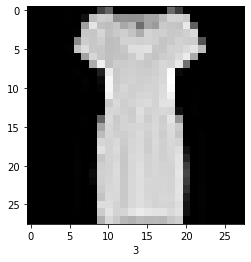

In [ ]:
plt.imshow(x_train[20],cmap='gray')
plt.xlabel(y_train[20])
plt.show()

In [ ]:
def create_model(hp):

    num_layer = 1
    num_units = 8
    dropout_rate = 0.1
    learning_rate = 0.01

    if hp!=None:
        num_layer = hp.Choice('num_layer',values=[1,2,3])
        num_units = hp.Choice('num_units',values=[8,16,32])
        dropout_rate = hp.Float('dropout_rate',min_value=0.1 ,max_value=0.5)
        learning_rate = hp.Float('learning_rate',min_value=0.0001 ,max_value=0.01)

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape = (28,28)))
    model.add(tf.keras.layers.Lambda(lambda x:x/255.0))

    for _ in range(0,num_layer):
        model.add(tf.keras.layers.Dense(units=num_units,activation='relu'))
        model.add(tf.keras.layers.Dropout(rate=dropout_rate))

    model.add(tf.keras.layers.Dense(units=10,activation='softmax'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    
    return model


In [ ]:
create_model(None).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
lambda (Lambda)              (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 8)                 6280      
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                90        
Total params: 6,370
Trainable params: 6,370
Non-trainable params: 0
_________________________________________________________________


In [ ]:
class CustomTuner(kerastuner.tuners.BayesianOptimization):
    def run_trial(self, trial, *arg ,**kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size',32,128,step=32)
        super(CustomTuner, self).run_trial(trial, *arg, **kwargs)

In [ ]:
tuner = CustomTuner(
    create_model,
    objective='val_accuracy',
    max_trials=20,
    directory='mydir',
    project_name='fashion_mnist',
    overwrite=True
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layer (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': None}


In [ ]:
tuner.search(
    x_train,y_train,
    validation_data=(x_test,y_test),
    epochs=5,
    verbose=1
)

Trial 20 Complete [00h 00m 31s]
val_accuracy: 0.8158000111579895

Best val_accuracy So Far: 0.8518000245094299
Total elapsed time: 00h 07m 43s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary(1)

Results summary
Results in mydir/fashion_mnist
Showing 1 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
num_layer: 1
num_units: 32
dropout_rate: 0.2878353297251804
learning_rate: 0.005131326196721497
batch_size: 96
Score: 0.8518000245094299


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=40, validation_data=(x_test,y_test))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/40
1875/1875 [==============================] - 5s 3ms/step - loss: 0.7126 - accuracy: 0.7384 - val_loss: 0.5135 - val_accuracy: 0.8219
Epoch 2/40
1875/1875 [==============================] - 5s 3ms/step - loss: 0.6006 - accuracy: 0.7786 - val_loss: 0.4932 - val_accuracy: 0.8262
Epoch 3/40
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5735 - accuracy: 0.7873 - val_loss: 0.4827 - val_accuracy: 0.8308
Epoch 4/40
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5659 - accuracy: 0.7893 - val_loss: 0.4875 - val_accuracy: 0.8252
Epoch 5/40
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5526 - accuracy: 0.7956 - val_loss: 0.4682 - val_accuracy: 0.8326
Epoch 6/40
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5436 - accuracy: 0.7974 - val_loss: 0.4410 - val_accuracy: 0.8412
Epoch 7/40
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5398 - accuracy: 0.7969 - val_loss: 0.4590 - val_accuracy: